# COVID-19 Literature Clustering

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
from Bio import Entrez
from Bio import Medline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [3]:
max_articles = 200
term = "Covid"

In [4]:
Entrez.email = 'A.N.Other@example.com'
h = Entrez.esearch(db='pubmed', retmax=max_articles, term=term)
result = Entrez.read(h)
result
ids = result['IdList']
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

In [5]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(records):

    if idx >max_articles:
        break
    try:
        dict_['paper_id'].append(entry["PMID"])
    except Exception as e:
        dict_['paper_id'].append("")
        
    try:
        dict_['abstract'].append(entry["AB"])
        # also create a column for the summary of abstract to be used in a plot
        if len(entry["AB"]) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(entry["AB"].split(' ')) > 100:
            # abstract provided is too long for plot, take first 100 words append with ...
            info = entry["AB"].split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(entry["AB"], 40)
            dict_['abstract_summary'].append(summary)
    except Exception as e:
        dict_['abstract'].append("")  
        dict_['abstract_summary'].append("Not provided.")

        
    try:
        dict_['body_text'].append(entry["AB"])
    except Exception as e:
        dict_['body_text'].append("")     
    
   
    
    
    try:
        # if more than one author
        authors = entry['AU'][0].split(',')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        try : 
            dict_['authors'].append(entry['AU'][0])
        except Exception as e:
            dict_['authors'].append("")


    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(entry['TI'][0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        try:
            dict_['title'].append(entry['TI'][0])
        except Exception as e:
            dict_['title'].append("")
    
    # add the journal information
    dict_['journal'].append(entry['PT'][0])
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          200 non-null    object
 1   abstract          200 non-null    object
 2   body_text         200 non-null    object
 3   authors           200 non-null    object
 4   title             200 non-null    object
 5   journal           200 non-null    object
 6   abstract_summary  200 non-null    object
dtypes: object(7)
memory usage: 11.1+ KB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [6]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160


In [7]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             200 non-null    object
 1   abstract             200 non-null    object
 2   body_text            200 non-null    object
 3   authors              200 non-null    object
 4   title                200 non-null    object
 5   journal              200 non-null    object
 6   abstract_summary     200 non-null    object
 7   abstract_word_count  200 non-null    int64 
 8   body_word_count      200 non-null    int64 
 9   body_unique_words    200 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 15.8+ KB


In [8]:
df_covid['abstract'].describe(include='all')

count     200
unique    142
top          
freq       59
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [9]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     142
unique    142
top          
freq        1
Name: abstract, dtype: object

In [10]:
df_covid['body_text'].describe(include='all')

count     142
unique    142
top          
freq        1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [11]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [12]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,142.000000,142.000000,142.000000
mean,226.436620,226.436620,140.880282
std,88.643318,88.643318,43.987826
min,0.000000,0.000000,0.000000
25%,179.250000,179.250000,117.250000
50%,232.000000,232.000000,144.500000
75%,259.750000,259.750000,169.000000
max,602.000000,602.000000,276.000000


# Data Pre-processing

### Réduction de la taille du dataset :

In [13]:

#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Suppression des valeurs null :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [14]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             142 non-null    object
 1   abstract             142 non-null    object
 2   body_text            142 non-null    object
 3   authors              142 non-null    object
 4   title                142 non-null    object
 5   journal              142 non-null    object
 6   abstract_summary     142 non-null    object
 7   abstract_word_count  142 non-null    int64 
 8   body_word_count      142 non-null    int64 
 9   body_unique_words    142 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 12.2+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [15]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 142/142 [00:02<00:00, 58.07it/s] 


In [16]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 142

{'en': 142}


Lets take a look at the language distribution in the dataset

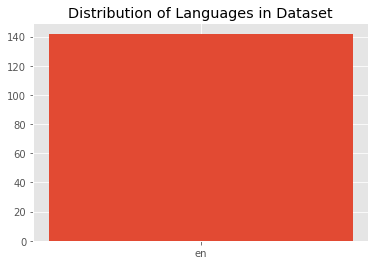

In [17]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [18]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 199
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             142 non-null    object
 1   abstract             142 non-null    object
 2   body_text            142 non-null    object
 3   authors              142 non-null    object
 4   title                142 non-null    object
 5   journal              142 non-null    object
 6   abstract_summary     142 non-null    object
 7   abstract_word_count  142 non-null    int64 
 8   body_word_count      142 non-null    int64 
 9   body_unique_words    142 non-null    int64 
 10  language             142 non-null    object
dtypes: int64(3), object(8)
memory usage: 13.3+ KB


In [19]:
#Download the spacy bio parser

from IPython.utils import io
# with io.capture_output() as captured:
#    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [20]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [21]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [22]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
print(stopwords)
print("-----------")

print(punctuations)

['between', 'five', 'many', 'hereupon', 'something', 'who', 'across', 'among', 'that', 'make', 'below', 'keep', 'of', 'towards', 'well', 'her', 'noone', 'see', 'against', 'may', 'any', 'else', 'our', 're', 'somehow', 'wherever', 'upon', 'every', 'during', 'alone', 'becomes', 'ten', 'almost', 'whereupon', "'ll", 'namely', 'hence', 'few', '‘ve', 'first', 'back', 'hereafter', 'meanwhile', 'everywhere', "'s", 'whose', 'i', "'d", 'will', 'part', 'even', 'neither', 'everything', 'up', 'to', 'an', 'do', 'but', 'you', 'ever', 'yours', 'none', 'front', 'n’t', 'rather', 'already', 'does', 'beforehand', 'less', 'put', 'would', 'he', 'a', 'ours', 'through', 'go', 'otherwise', 'my', 'n‘t', 'formerly', 'seemed', 'throughout', 'where', 'it', 'take', 'three', 'though', 'until', 'me', 'although', 'toward', 'on', 'once', 'off', 'herein', 'another', 'other', 'they', 'four', 'or', 'ourselves', 'could', 'mostly', 'last', 'itself', 'nevertheless', 'former', 'yourself', 'such', 'above', 'just', 'however', 's

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [23]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [24]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [ word for word in mytokens if word not in stopwords and word.text not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [25]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#c'est dans cette partie la que ça bug , ça prend un temps énorme et on a pas eu de résultat  
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

In [26]:
import spacy
nlp = en_core_web_lg.load()
def spacy_process(texte):
    tmp = []
    tmp.append(texte)
    for lt in tmp:
        mytokens = nlp(lt)
        mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]
        mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

### Exemple

In [27]:
test1 = spacy_process("vaccinations")
test2 = spacy_process("vaccination")
test3 = spacy_process("vaccinating")
test4 = spacy_process("vaccinated")
print(test1)
print(test2)
print(test3)
print(test4)

vaccination
vaccination
vaccinate
vaccinate


In [28]:
df.head()


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136,en,background reverse transcriptase quantitative ...
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216,en,this article aim analyse implementation public...
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189,en,the aim study study effectiveness complex trea...
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138,en,background the impact covid-19 pandemic functi...
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160,en,the clinical manifestation covid-19 heterogene...


In [29]:
nlp = en_core_web_lg.load()

tmp = "The COVID-19 pandemic poses new challenges"
for lt in tmp:
    mytokens = nlp(lt)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens]
    mytokens2 = " ".join([i for i in mytokens2])
    print(mytokens2)


t
h
e

c
o
v
i
d
-
1
9

p
a
n
d
e
m
i
c

p
o
s
e
s

n
e
w

c
h
a
l
l
e
n
g
e
s


In [30]:
processed_text = df["processed_text"]
body_text = df["body_text"]

for i in range(1,30):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print("----------------------------------------------------------")



This article aims to analyse the implementation of public procurement procedures in the context of national governments' fight against the COVID-19 pandemic and find solutions for adapting those public procurement procedures that are currently used in the healthcare sector to new challenges. For this above purpose, we have applied both theoretical methods such as analysis, synthesis, generalization, and empirical methods such as observation, etc. The research has yielded the following findings: 1) there are no one-size-fits-all solutions in the national governments' fight against the COVID-19 pandemic through the public procurement mechanism, except that national policies in this field intend to speed up the organisation of the public procurement procedures, which would shorten the time for the delivery of medical goods to healthcare facilities; 2) due to the current emergency conditions caused by the COVID-19 pandemic, public procurements of medical supplies are taking place under the

KeyError: 18

### Removal of Frequent words
So this step is to remove the frequent words in the given corpus. If we use something like tfidf, this is automatically taken care of.

In [31]:
from collections import Counter
cnt = Counter()
for text in df["processed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(40)

[('covid-19', 401),
 ('%', 242),
 ('the', 234),
 ('patient', 222),
 ('sars', 200),
 ('-', 198),
 ('cov-2', 193),
 ('study', 150),
 ('pandemic', 146),
 ('result', 126),
 ('health', 126),
 ('infection', 106),
 ('high', 92),
 ('we', 90),
 ('case', 88),
 ('include', 86),
 ('increase', 84),
 ('report', 84),
 ('disease', 82),
 ('risk', 81),
 ('method', 78),
 ('2020', 77),
 ('in', 76),
 ('this', 73),
 ('level', 72),
 ('analysis', 70),
 ('/', 67),
 ('vaccine', 65),
 ('model', 64),
 ('severe', 63),
 ('virus', 63),
 ('compare', 62),
 ('associate', 61),
 ('age', 59),
 ('care', 58),
 ('day', 56),
 ('time', 56),
 ('=', 55),
 ('rate', 55),
 ('conclusion', 54)]

In [32]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


In [33]:
df["body_text"]

0      BACKGROUND: Reverse transcriptase-quantitative...
1      This article aims to analyse the implementatio...
2      The aim of the study was to study the effectiv...
3      BACKGROUND: The impact of the COVID-19 pandemi...
4      The clinical manifestations of COVID-19 are he...
                             ...                        
195    Preliminary prospective research suggests emot...
196    Achieving promotion in rank is considered an i...
197    OBJECTIVES: In the face of the SARS-CoV-2 pand...
198    OBJECTIVES: This study aimed to investigate an...
199    OBJECTIVES: The objective of the study is to c...
Name: body_text, Length: 142, dtype: object

In [34]:
df["text_wo_stopfreq"]

0      background reverse transcriptase quantitative ...
1      article aim analyse implementation public proc...
2      aim effectiveness complex treatment decompensa...
3      background impact functional exercise capacity...
4      clinical manifestation heterogeneous 46.4 admi...
                             ...                        
195    preliminary prospective research suggest emoti...
196    achieve promotion rank consider important meas...
197    objective face people dementia carer contend c...
198    objective aim investigate synthesize current e...
199    objective objective compare excess mortality e...
Name: text_wo_stopfreq, Length: 142, dtype: object

In [35]:
df["processed_text"]

0      background reverse transcriptase quantitative ...
1      this article aim analyse implementation public...
2      the aim study study effectiveness complex trea...
3      background the impact covid-19 pandemic functi...
4      the clinical manifestation covid-19 heterogene...
                             ...                        
195    preliminary prospective research suggest emoti...
196    achieve promotion rank consider important meas...
197    objective in face sars cov-2 pandemic people d...
198    objective this study aim investigate synthesiz...
199    objective the objective study compare excess m...
Name: processed_text, Length: 142, dtype: object

### Removal of Rare words
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [36]:
#cnt.most_common()[:-500-1:-1]

In [37]:
# n_rare_words = 10
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# def remove_rarewords(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
# df.head()

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

In [38]:
import nltk
#nltk.download('wordnet')

Now let us redo the lemmatization process for our dataset.

In [39]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [40]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


In [41]:
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136,en,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216,en,this article aim analyse implementation public...,article aim analyse implementation public proc...,article aim analyse implementation public proc...
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189,en,the aim study study effectiveness complex trea...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138,en,background the impact covid-19 pandemic functi...,background impact functional exercise capacity...,background impact functional exercise capacity...
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160,en,the clinical manifestation covid-19 heterogene...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...


In [42]:
processed_text = df["processed_text"]
body_text = df["body_text"]
text_lemmatized = df["text_lemmatized"]

for i in range(1,30):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print(text_lemmatized[i])
    print("----------------------------------------------------------")



This article aims to analyse the implementation of public procurement procedures in the context of national governments' fight against the COVID-19 pandemic and find solutions for adapting those public procurement procedures that are currently used in the healthcare sector to new challenges. For this above purpose, we have applied both theoretical methods such as analysis, synthesis, generalization, and empirical methods such as observation, etc. The research has yielded the following findings: 1) there are no one-size-fits-all solutions in the national governments' fight against the COVID-19 pandemic through the public procurement mechanism, except that national policies in this field intend to speed up the organisation of the public procurement procedures, which would shorten the time for the delivery of medical goods to healthcare facilities; 2) due to the current emergency conditions caused by the COVID-19 pandemic, public procurements of medical supplies are taking place under the

KeyError: 18

### Removal of URLs

In [43]:
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [44]:
df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))
df.head()
    

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136,en,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216,en,this article aim analyse implementation public...,article aim analyse implementation public proc...,article aim analyse implementation public proc...,article aim analyse implementation public proc...
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189,en,the aim study study effectiveness complex trea...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138,en,background the impact covid-19 pandemic functi...,background impact functional exercise capacity...,background impact functional exercise capacity...,background impact functional exercise capacity...
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160,en,the clinical manifestation covid-19 heterogene...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...


### Removal of HTML Tags

In [45]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [46]:
df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html
0,33964860,BACKGROUND: Reverse transcriptase-quantitative...,BACKGROUND: Reverse transcriptase-quantitative...,Hammerling MJ,L,Journal Article,BACKGROUND: Reverse<br>transcriptase-quantita...,218,218,136,en,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...,background reverse transcriptase quantitative ...
1,33964845,This article aims to analyse the implementatio...,This article aims to analyse the implementatio...,Ustymenko V,[,English Abstract,This article aims to analyse the<br>implement...,389,389,216,en,this article aim analyse implementation public...,article aim analyse implementation public proc...,article aim analyse implementation public proc...,article aim analyse implementation public proc...,article aim analyse implementation public proc...
2,33964818,The aim of the study was to study the effectiv...,The aim of the study was to study the effectiv...,Krylov A,[,English Abstract,The aim of the study was to study the<br>effe...,335,335,189,en,the aim study study effectiveness complex trea...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...,aim effectiveness complex treatment decompensa...
3,33964817,BACKGROUND: The impact of the COVID-19 pandemi...,BACKGROUND: The impact of the COVID-19 pandemi...,Martin I,F,Journal Article,BACKGROUND: The impact of the COVID-19<br>pan...,258,258,138,en,background the impact covid-19 pandemic functi...,background impact functional exercise capacity...,background impact functional exercise capacity...,background impact functional exercise capacity...,background impact functional exercise capacity...
4,33964815,The clinical manifestations of COVID-19 are he...,The clinical manifestations of COVID-19 are he...,Ferrarotti I,C,Journal Article,The clinical manifestations of COVID-19 are<b...,247,247,160,en,the clinical manifestation covid-19 heterogene...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...,clinical manifestation heterogeneous 46.4 admi...


### Let's take a look at word count in the papers

In [47]:
import seaborn as sns

C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    142.000000
mean     226.436620
std       88.643318
min        0.000000
25%      179.250000
50%      232.000000
75%      259.750000
max      602.000000
Name: body_word_count, dtype: float64

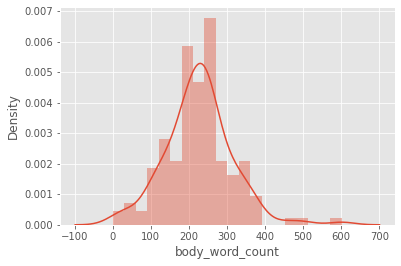

In [48]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    142.000000
mean     140.880282
std       43.987826
min        0.000000
25%      117.250000
50%      144.500000
75%      169.000000
max      276.000000
Name: body_unique_words, dtype: float64

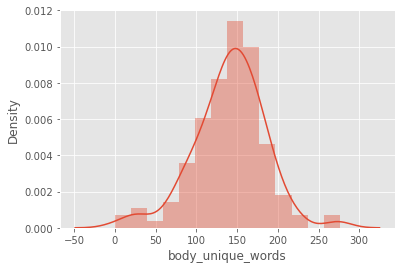

In [49]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [51]:
text = df['text_lemmatized_url_html'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text, 2 ** 12)
X.shape
print(X)

  (0, 429)	0.05646180792479528
  (0, 2935)	0.05646180792479528
  (0, 525)	0.054882029531244714
  (0, 2470)	0.035264852193494005
  (0, 1310)	0.07901398469442782
  (0, 1496)	0.06023002319317031
  (0, 2760)	0.07901398469442782
  (0, 1908)	0.046925775323473355
  (0, 1919)	0.07901398469442782
  (0, 489)	0.07293443000424213
  (0, 894)	0.029876388799086294
  (0, 1103)	0.06254136261498099
  (0, 205)	0.04783478252664439
  (0, 1255)	0.07293443000424213
  (0, 1603)	0.07901398469442782
  (0, 1193)	0.07901398469442782
  (0, 2213)	0.07901398469442782
  (0, 1117)	0.046925775323473355
  (0, 1072)	0.08351045567291736
  (0, 152)	0.10189626544630015
  (0, 3501)	0.07293443000424213
  (0, 3293)	0.06023002319317031
  (0, 354)	0.04525805517177325
  (0, 2228)	0.06254136261498099
  (0, 2570)	0.05646180792479528
  :	:
  (141, 754)	0.034848928532920535
  (141, 1222)	0.048488625278782574
  (141, 2804)	0.033079995594148384
  (141, 863)	0.030459334889310397
  (141, 2083)	0.1105113904191836
  (141, 1071)	0.091378004

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(142, 129)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [53]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [54]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

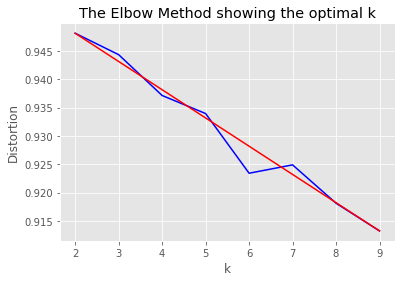

In [55]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [56]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred
df['y']

0      1
1      1
2      3
3      3
4      3
      ..
195    1
196    1
197    3
198    3
199    3
Name: y, Length: 142, dtype: int32

# Dimensionality Reduction with t-SNE

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 141 nearest neighbors...
[t-SNE] Indexed 142 samples in 0.002s...
[t-SNE] Computed neighbors for 142 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 142 / 142
[t-SNE] Mean sigma: 0.495796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.151432
[t-SNE] KL divergence after 650 iterations: 1.004187


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


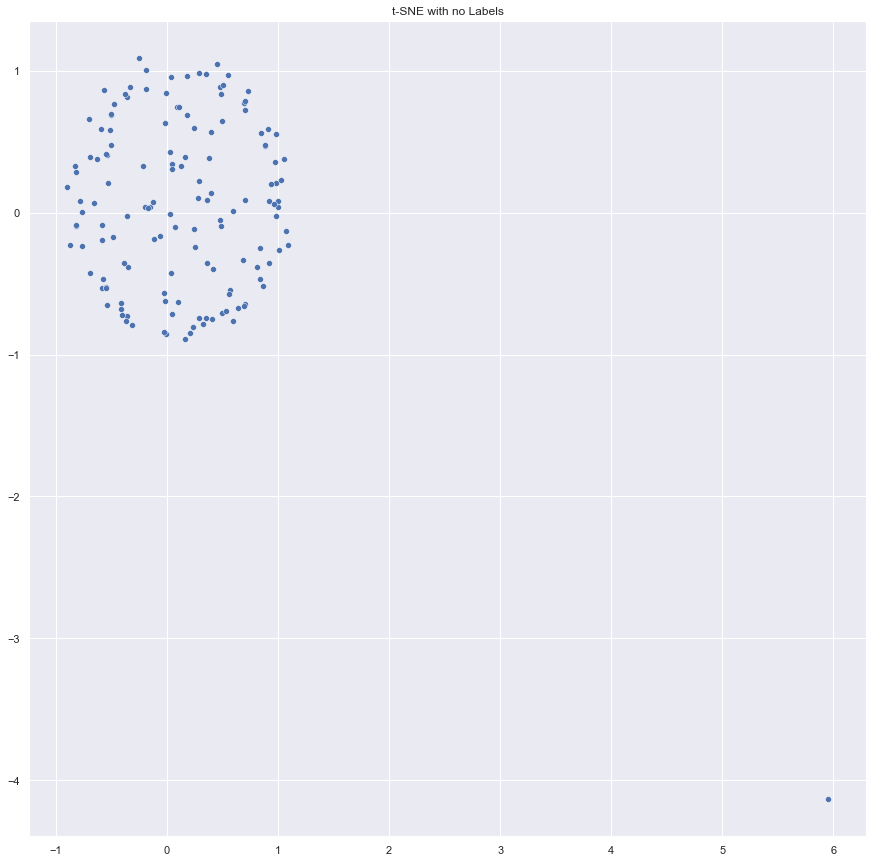

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


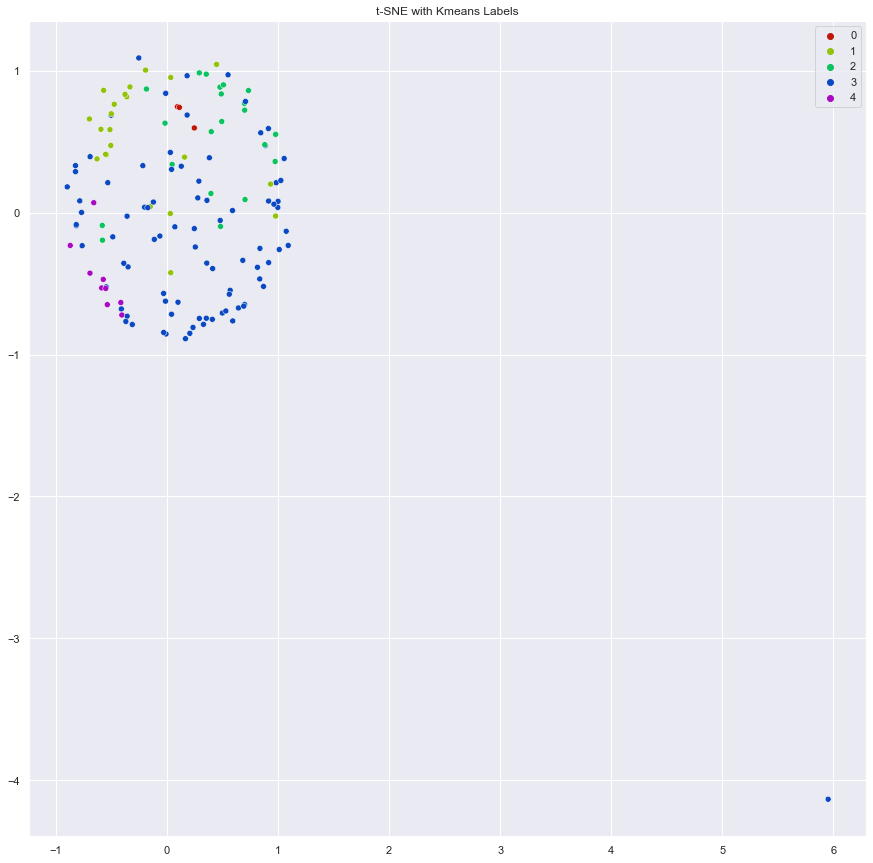

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# NMF

In [60]:
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [61]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components=20, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X)

In [62]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [63]:
#vectorizer = TfidfVectorizer(max_features= 2 ** 12)


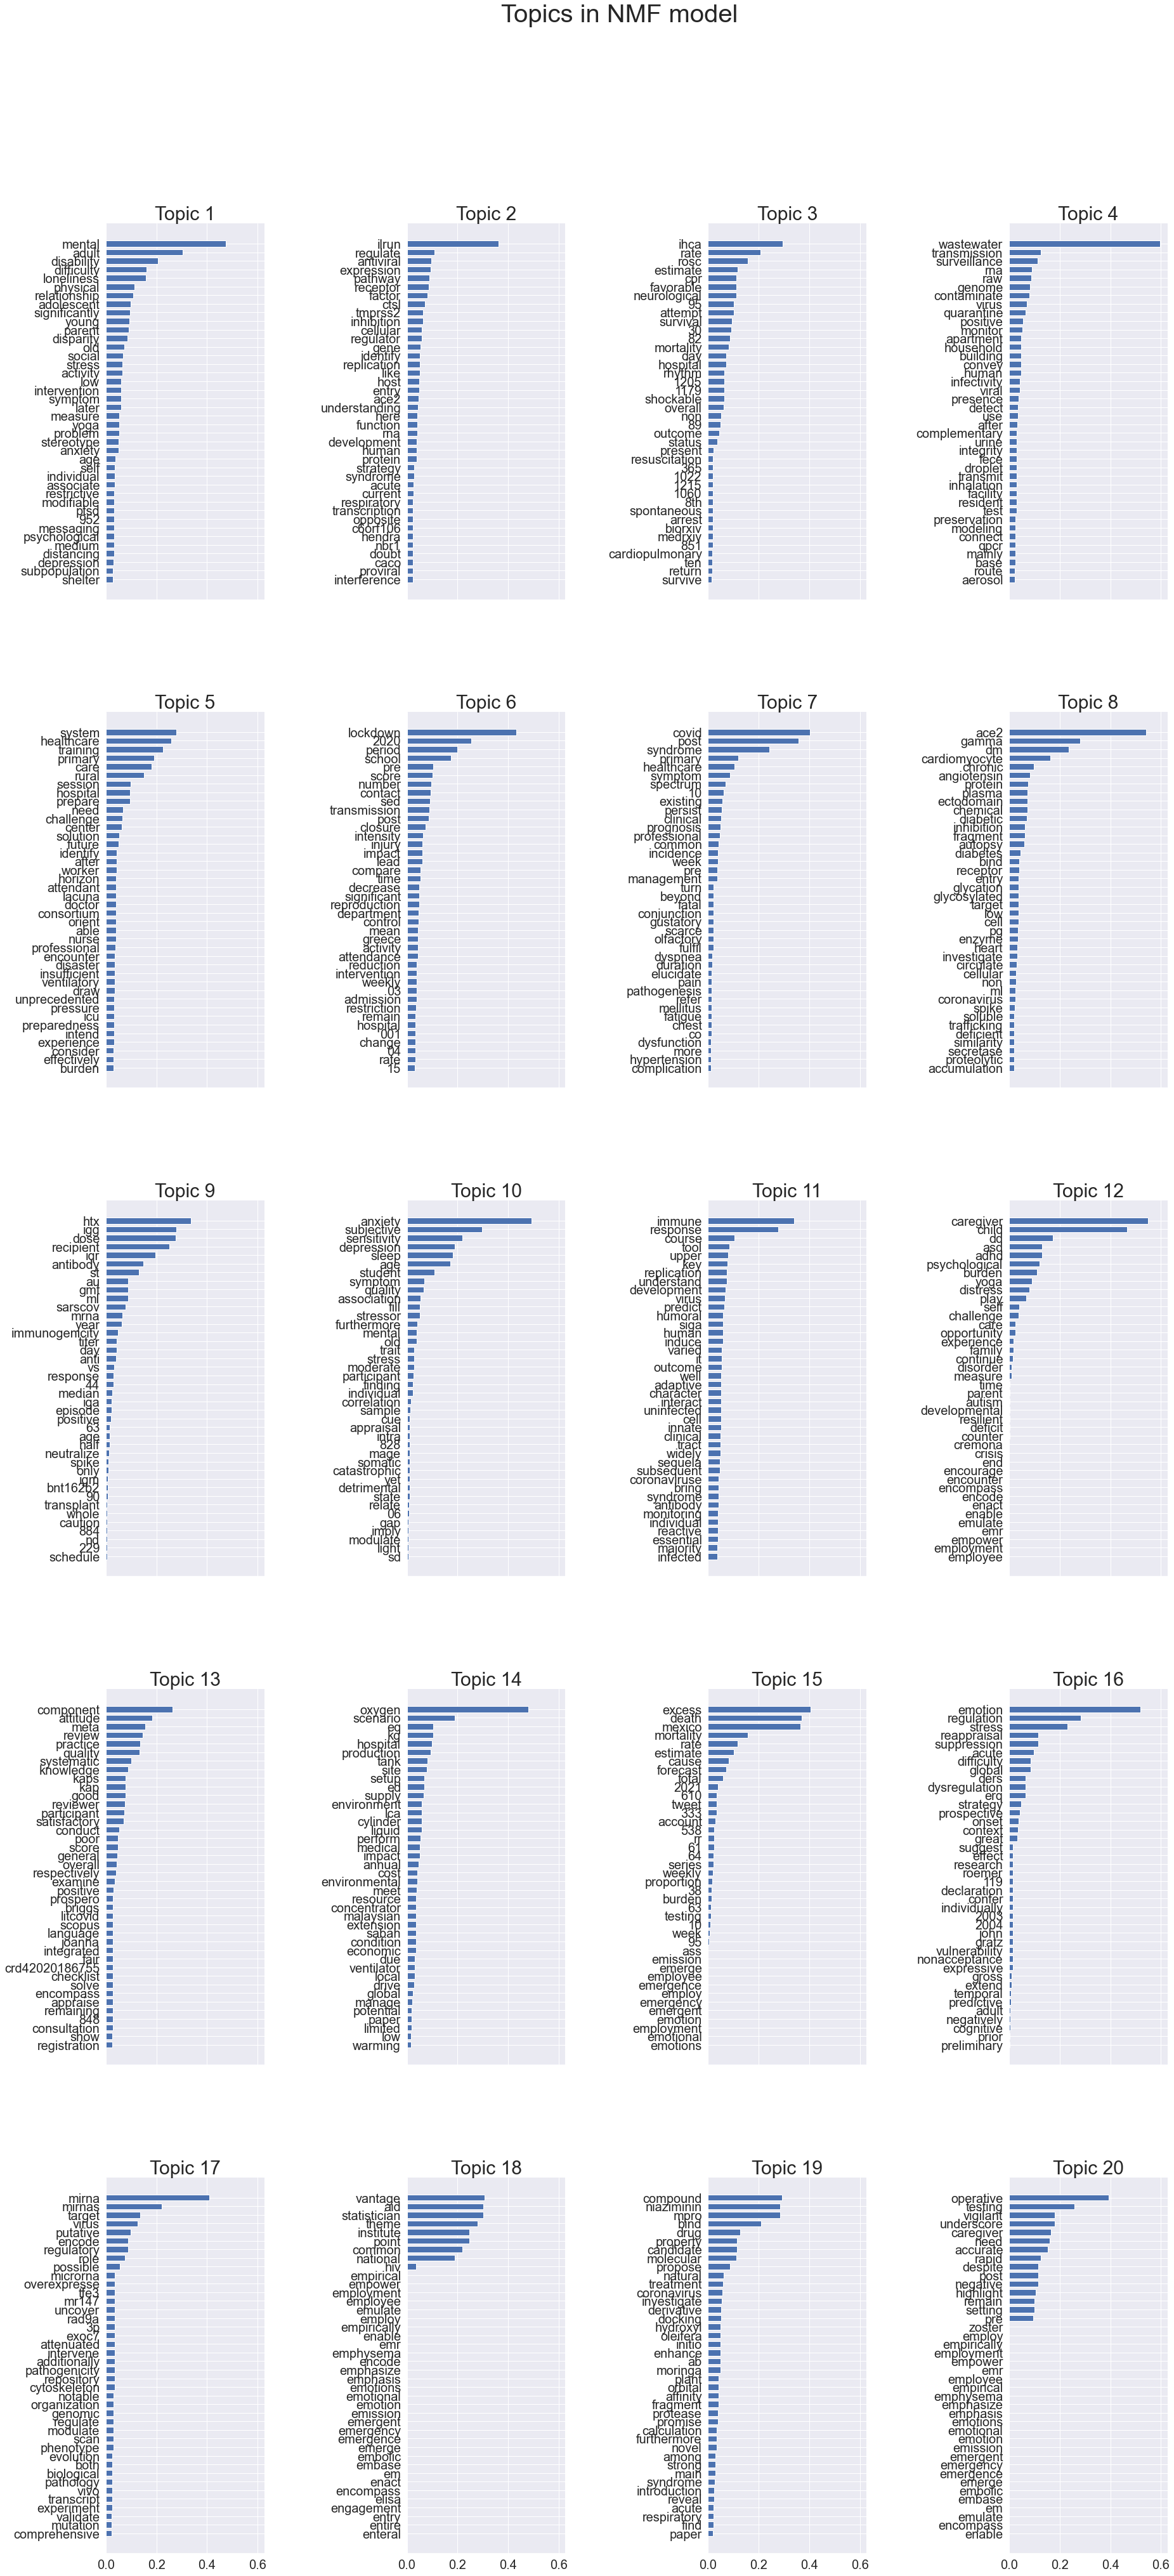

In [64]:
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 40,
               'Topics in NMF model')

In [65]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [66]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
mental,adult,disability,difficulty,loneliness,physical,relationship,adolescent,significantly,young,parent,disparity,old,social,stress,activity,low,intervention,symptom,later,measure,yoga,problem,stereotype,anxiety,age,self,individual,associate,restrictive,modifiable,ptsd,952,messaging,psychological,medium,distancing,depression,subpopulation,shelter
-------------------------------------------
TERM_LIST :  ['anxiety', 'depression']

*************Cluster  1 *********************
ilrun,regulate,antiviral,expression,pathway,receptor,factor,ctsl,tmprss2,inhibition,cellular,regulator,gene,identify,replication,like,host,entry,ace2,understanding,here,function,rna,development,human,protein,strategy,syndrome,acute,current,respiratory,transcription,opposite,c6orf106,hendra,nbr1,doubt,caco,proviral,interference
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
ihca,rate,rosc,estimate,cpr,favorable

# Word's Similarity

In [67]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,words)
    print("")
    for token in doc:
        #print(token.text, token.has_vector, token.vector_norm, token.is_oov) 
        if cov_word.similarity(token) > 0.5 :
            print("Similarity Between {",cov_word,"} and {",token,"} is :   ",cov_word.similarity(token))
    print("__________________________________________________________________")


*************Cluster  0 *********************
mental adult disability difficulty loneliness physical relationship adolescent significantly young parent disparity old social stress activity low intervention symptom later measure yoga problem stereotype anxiety age self individual associate restrictive modifiable ptsd 952 messaging psychological medium distancing depression subpopulation shelter
-------------------------------------------
TERM_LIST :  []

__________________________________________________________________
*************Cluster  1 *********************
ilrun regulate antiviral expression pathway receptor factor ctsl tmprss2 inhibition cellular regulator gene identify replication like host entry ace2 understanding here function rna development human protein strategy syndrome acute current respiratory transcription opposite c6orf106 hendra nbr1 doubt caco proviral interference
-------------------------------------------
TERM_LIST :  []

_______________________________________

<ipython-input-67-a9ecc4291df1>:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


__________________________________________________________________
*************Cluster  3 *********************
wastewater transmission surveillance rna raw genome contaminate virus quarantine positive monitor apartment household building convey human infectivity viral presence detect use after complementary urine integrity fece droplet transmit inhalation facility resident test preservation modeling connect qpcr mainly base route aerosol
-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus } and { virus } is :    0.9999999598655379
Similarity Between { coronavirus } and { quarantine } is :    0.5746238784930114
Similarity Between { coronavirus } and { infectivity } is :    0.5350284756573006
Similarity Between { coronavirus } and { viral } is :    0.6789279758381194
__________________________________________________________________
*************Cluster  4 *********************
system healthcare training primary care rural session hospital prep

In [68]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
top_similar = []
for num_clus in range(0,20):
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    for token in doc:
        if cov_word.similarity(token) > 0.5 :
            top_similar.append((token.text , cov_word.similarity(token)))
LL = top_similar
top_similar_sorted = []
for a in top_similar :
    if a not in top_similar_sorted:
        top_similar_sorted.append(a)
top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
top_similar_sorted

<ipython-input-68-7ae6cfacfccd>:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


[('coronavirus', 1.0),
 ('virus', 0.9999999598655379),
 ('uninfected', 0.7662567525882018),
 ('infected', 0.7662567525882018),
 ('viral', 0.6789279758381194),
 ('zoster', 0.5938582289935102),
 ('immunogenicity', 0.5881906817418034),
 ('quarantine', 0.5746238784930114),
 ('infectivity', 0.5350284756573006),
 ('pathogenicity', 0.5350284756573006),
 ('pathogenesis', 0.5332051459892988),
 ('immune', 0.524877441820188),
 ('humoral', 0.524877441820188)]

In [69]:
li = top_similar_sorted[0:10]

In [70]:
nlp = spacy.load('en_core_web_md')
lii = []
for tup in li:
    cov_word =nlp(tup[0])
    top_similar = []
    for num_clus in range(0,20):
        str1 = ' '.join(all_keywords[num_clus])
        doc = nlp(str1)
        words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        for token in doc:
            if cov_word.similarity(token) > 0.5 :
                top_similar.append((token.text , cov_word.similarity(token)))
    top_similar_sorted = []
    for a in top_similar :
        if a not in top_similar_sorted:
            top_similar_sorted.append(a)
    top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
    top_similar_sorted = top_similar_sorted[0:10]
    lii.append((tup[0],top_similar_sorted))
# LL = top_similar
# top_similar_sorted = []
# for a in top_similar :
#     if a not in top_similar_sorted:
#         top_similar_sorted.append(a)
# top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
# top_similar_sorted
top_ten_of_ten = lii
top_ten_of_ten

<ipython-input-70-241254ade84c>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


[('coronavirus',
  [('coronavirus', 1.0),
   ('virus', 0.9999999598655379),
   ('uninfected', 0.7662567525882018),
   ('infected', 0.7662567525882018),
   ('viral', 0.6789279758381194),
   ('zoster', 0.5938582289935102),
   ('immunogenicity', 0.5881906817418034),
   ('quarantine', 0.5746238784930114),
   ('infectivity', 0.5350284756573006),
   ('pathogenicity', 0.5350284756573006)]),
 ('virus',
  [('virus', 1.0),
   ('coronavirus', 0.9999999598655379),
   ('uninfected', 0.7662567525882018),
   ('infected', 0.7662567525882018),
   ('viral', 0.6789279758381194),
   ('zoster', 0.5938582289935102),
   ('immunogenicity', 0.5881906817418034),
   ('quarantine', 0.5746238784930114),
   ('infectivity', 0.5350284756573006),
   ('pathogenicity', 0.5350284756573006)]),
 ('uninfected',
  [('uninfected', 1.0),
   ('infected', 0.9999999718503632),
   ('virus', 0.7662567171960497),
   ('coronavirus', 0.7662567171960497),
   ('zoster', 0.5666696189720654),
   ('titer', 0.5637537602579952),
   ('infecti

In [71]:

ten_diseases = []
for i,mots in top_similar_sorted :
    if mots not in ten_diseases:
        ten_diseases.append(i)
ten_diseases

['pathogenicity',
 'infectivity',
 'antiviral',
 'pathogenesis',
 'viral',
 'glycation',
 'enzyme',
 'proteolytic',
 'antibody',
 'cytoskeleton']

In [72]:
hundred_diseases = []
for i,mots in top_ten_of_ten :
    for mot,val in mots:
        if mot not in hundred_diseases:
            hundred_diseases.append(mot)
hundred_diseases


['coronavirus',
 'virus',
 'uninfected',
 'infected',
 'viral',
 'zoster',
 'immunogenicity',
 'quarantine',
 'infectivity',
 'pathogenicity',
 'titer',
 'immune',
 'hiv',
 'onset',
 'pathogenesis',
 'antiviral',
 'contaminate',
 'glycation',
 'enzyme',
 'proteolytic',
 'antibody',
 'cytoskeleton']

In [73]:
print(lemmatizer.lemmatize("diabete"))
print(lemmatizer.lemmatize("diabetes"))
print(lemmatizer.lemmatize("diabetic"))

print(lemmatizer.lemmatize("feet"))

print(lemmatizer.lemmatize("vaccinations"))
print(lemmatizer.lemmatize("vaccination"))
print(lemmatizer.lemmatize("vaccinated"))

print(lemmatizer.lemmatize("speaking"))
print(lemmatizer.lemmatize("speaks"))
print(lemmatizer.lemmatize("spoken"))



diabete
diabetes
diabetic
foot
vaccination
vaccination
vaccinated
speaking
speaks
spoken


# LDA

In [109]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [102]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tff = tf.fit_transform(text)
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42)
lda.fit(tff)


LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42)

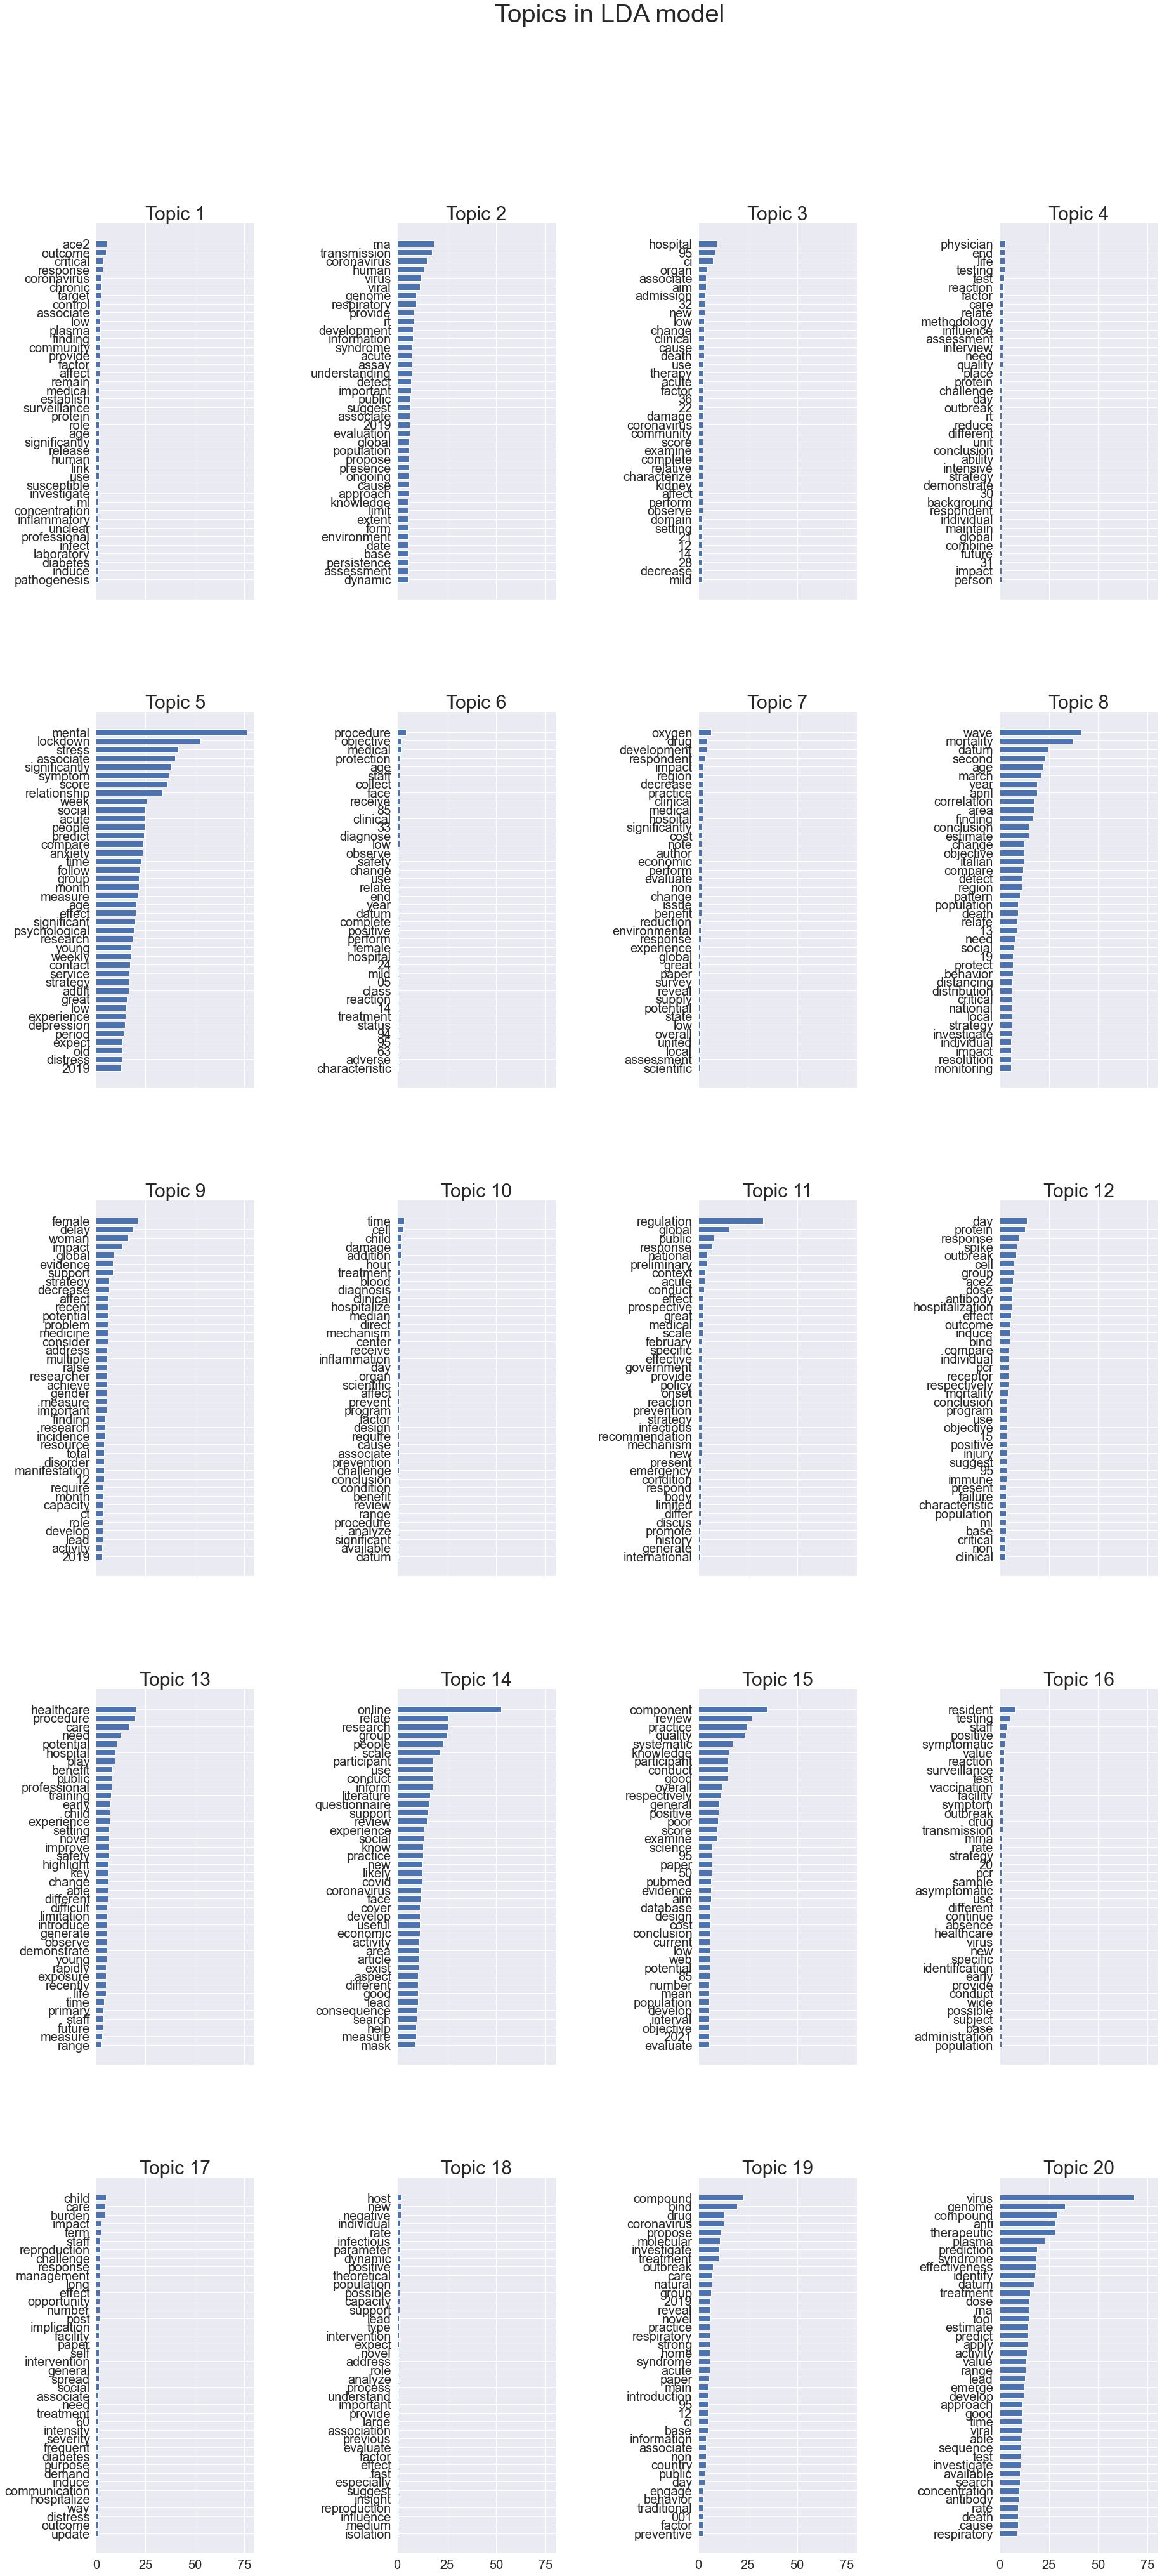

In [103]:
tf_feature_names = tf.get_feature_names()
plot_top_words(lda, tf_feature_names, 40, 'Topics in LDA model')

In [106]:
all_keywords = []
for topic_idx, topic in enumerate(lda.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [111]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST)
    print("")

*************Cluster  0 *********************
14040,although,43,attitude,3p,28,biliary,39,2004,advection,anecdotal,894,31,approximately,851,1775,astroviruse,aftermath,7694,belong,approximate,auc,1776037,awareness,astrazeneca,absence,admission,bootstrap,bergamo,actor,agreement,334,ace2,bm,aos,accuracy,address,54,accumulation,amidst,ama,apartment,244,boy,bear,academia,10,234,appropriate,asia,624,arthritis,309,aforementioned,abstratthe,birth,avenue,aprotinin,angiotensin,76,283,behaviour,anticoagulant,bpm,344,251,availability,500,179,between,algorithm,announcement,24,biontech,74,biologic,880,announce,245,aspartate,25,accord,alongside,ast,aat,231,baricitinib,66,63,add,behavioral,adolescent,anti,aatd,2352,blame,443,atmosphere,accurate,aicc
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
au,black,3p,absence,bpm,boy,95,attentive,approximately,auditory,539,acidification,bias,149,20,bnt162b2,52,acceptable,aprotinin,behaviour,2004,022,79,

4481,approximate,attitude,baricitinib,alternative,244,965,14040,62,188,abnormality,66,although,accumulation,2196,32,accumulate,among,aspartate,attention,air,342,appear,bootstrap,allergy,01,announce,acknowledge,behaviour,122,abstratthe,anti,86,261,animal,agreement,2019,43,alignment,29,2018,293,accident,58,1st,39,056,attentive,authority,35,78,8472,283,building,045,advanced,74,562,007,basis,aicc,448,1022,allergic,anemic,almost,adolescent,234,article,associate,applicability,083,472,auto,65,98,about,052,005,addition,2004,962,binomial,82,2011,334,airborne,alt,anticipate,0004,185,amazon,1215,24,2009,92,bear,050,academia,bradycardic
-------------------------------------------
TERM_LIST :  []

*************Cluster  12 *********************
99,antiviral,2352,alanine,annually,abnormal,anemia,216,aprotinin,aos,birth,65,267,83,available,allergenic,acceptance,augment,abbott,addition,251,1273,562,565,administer,actively,94,alliance,500,burden,arthroscopic,8472,asos,adherence,biontech,antiprotease,bas

# LSA

In [112]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [78]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [79]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0] ," ",end='')
    print(" ")

Topic 0: 
care  response  lockdown  virus  day  clinical  mortality   
Topic 1: 
mental  adult  lockdown  anxiety  age  old  child   
Topic 2: 
day  95  estimate  igg  death  outbreak  dose   
Topic 3: 
wastewater  mental  virus  testing  resident  rna  pcr   
Topic 4: 
healthcare  care  outbreak  system  testing  staff  procedure   
Topic 5: 
lockdown  2020  period  school  injury  death  post   
Topic 6: 
ace2  post  lockdown  covid  testing  caregiver  child   
Topic 7: 
ace2  mask  diabetes  wear  face  respondent  dm   
Topic 8: 
virus  wastewater  genome  mortality  child  sequence  mutation   
Topic 9: 
review  drug  outbreak  compound  wastewater  resident  systematic   
Topic 10: 
response  immune  cytokine  outbreak  course  mask  wear   
Topic 11: 
mask  face  wear  drug  antibody  compound  respondent   
Topic 12: 
caregiver  child  operative  post  death  testing  care   
Topic 13: 
child  oxygen  caregiver  play  yoga  global  aid   
Topic 14: 
outbreak  care  home  menta

In [80]:
all_keywords = []
for topic_idx, topic in enumerate(svd_model.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)


In [81]:
for num_clus in range(0,19):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
care,response,lockdown,virus,day,clinical,mortality,mental,age,review,outbreak,hospital,group,rate,outcome,symptom,system,coronavirus,associate,compare,adult,research,datum,death,year,change,need,healthcare,time,syndrome,individual,old,test,respiratory,public,identify,use,low,new,95
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
mental,adult,lockdown,anxiety,age,old,child,2020,disability,year,depression,social,measure,physical,score,difficulty,stress,people,mean,relate,significantly,loneliness,yoga,young,associate,self,mask,psychological,intervention,parent,stereotype,relationship,face,wear,subjective,sexual,compare,95,experience,symptom
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
day,95,estimate,igg,death,outbreak,dose,mortality,resident,testing,ci,pcr,antibody,rate,test,year,30,hospitalization,excess,episode,positive,

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [82]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [83]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Now we will vectorize the data from each of our clusters

In [84]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'text_lemmatized_url_html']))
        #d'ou vient df['y'] =   y_pred = kmeans.fit_predict(X_reduced)      df['y'] = y_pred       df['y']
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 0


In [85]:
len(vectorized_data)

5

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

# Topic modeling on each cluster using LDA : 

In [113]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [86]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [87]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [88]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [89]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [90]:
for i in range(0,5):
    print(all_keywords[i])

['public', 'global', 'hospital', 'develop', 'resource', 'need', 'condition', 'activity', 'response', 'emergency', 'challenge', 'new', 'population', 'reduce', 'respond', 'present', 'potential', 'ass', 'measure', 'effect', 'direct', 'impact', 'strategy', 'novel', 'care', 'provide', 'conclusion', 'time', 'research', 'change', 'affect']
['identify', 'respiratory', 'acute', 'coronavirus', 'syndrome', 'protein', 'research', 'development', 'develop', 'human', 'virus', 'use', 'novel', 'conclusion', 'associate', 'cause', 'finding', 'help', 'effect', 'cell', 'response', 'viral', 'public', 'immune', 'predict', 'suggest', 'provide']
['age', 'estimate', 'death', 'old', 'associate', 'rate', 'dose', 'outcome', 'review', 'adult', 'year', 'lockdown', 'individual', 'positive', 'resident', 'mean', 'hospitalization', 'home', 'mental', 'compare', 'month', 'research', 'anxiety', 'respiratory', 'mortality', 'post', 'practice', 'develop', 'virus', 'finding', 'staff', 'outbreak', 'rna', 'syndrome', 'online', '

IndexError: list index out of range

In [91]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
public,global,hospital,develop,resource,need,condition,activity,response,emergency,challenge,new,population,reduce,respond,present,potential,ass,measure,effect,direct,impact,strategy,novel,care,provide,conclusion,time,research,change,affect
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
identify,respiratory,acute,coronavirus,syndrome,protein,research,development,develop,human,virus,use,novel,conclusion,associate,cause,finding,help,effect,cell,response,viral,public,immune,predict,suggest,provide
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
age,estimate,death,old,associate,rate,dose,outcome,review,adult,year,lockdown,individual,positive,resident,mean,hospitalization,home,mental,compare,month,research,anxiety,respiratory,mortality,post,practice,develop,virus,finding,staff,outbreak,rna,syndrome,online,pcr,period,test,newly,m

IndexError: list index out of range

# Topic modeling on each cluster using NMF : 

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [92]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

nmf_models = []
for ii in range(0, 5):
    # nmf
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, random_state=1,alpha=.1, l1_ratio=.5)
    nmf_models.append(nmf)
    
nmf_models[0]

NMF(alpha=0.1, l1_ratio=0.5, n_components=6, random_state=1)

In [93]:
clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4


C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\moham\anaconda3\envs\Data2\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [94]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [95]:
all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))

In [96]:
for i in range(0,5):
    print(all_keywords[i])

['public', 'hospital', 'condition', 'emergency', 'need', 'response', 'measure', 'impact', 'develop', 'provide', 'activity', 'conclusion', 'potential', 'strategy', 'new', 'direct', 'challenge', 'effect', 'research', 'time', 'global', 'ass', 'respond', 'affect', 'population', 'reduce', 'resource', 'change', 'present', 'novel', 'care']
['protein', 'use', 'response', 'suggest', 'research', 'human', 'predict', 'viral', 'cell', 'coronavirus', 'provide', 'respiratory', 'acute', 'syndrome', 'immune', 'cause', 'public', 'development', 'effect', 'novel', 'associate', 'identify', 'help', 'finding', 'virus', 'develop', 'conclusion']
['death', 'age', 'outbreak', 'antibody', 'resident', 'rate', 'mortality', 'home', 'estimate', 'care', 'year', 'old', 'staff', 'develop', 'anxiety', 'time', 'lockdown', 'program', 'treatment', 'dose', 'practice', 'define', 'newly', 'cause', 'day', 'strategy', 'individual', 'value', 'datum', 'change', 'pcr', 'require', 'mental', 'significant', 'review', 'compare', 'analy

IndexError: list index out of range

## travail realisé :
 - detection automatique des noms de maladies
 - construction d'un corpus en utilisant les noms des maladies detectés

In [97]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")


*************Cluster  0 *********************
public,hospital,condition,emergency,need,response,measure,impact,develop,provide,activity,conclusion,potential,strategy,new,direct,challenge,effect,research,time,global,ass,respond,affect,population,reduce,resource,change,present,novel,care
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
protein,use,response,suggest,research,human,predict,viral,cell,coronavirus,provide,respiratory,acute,syndrome,immune,cause,public,development,effect,novel,associate,identify,help,finding,virus,develop,conclusion
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
death,age,outbreak,antibody,resident,rate,mortality,home,estimate,care,year,old,staff,develop,anxiety,time,lockdown,program,treatment,dose,practice,define,newly,cause,day,strategy,individual,value,datum,change,pcr,require,mental,significant,review,compare,analyze,relate,approach,total,o

IndexError: list index out of range

In [98]:
from Bio import Entrez
from Bio import Medline
import json


MAX_COUNT = 3
for TERM in ten_diseases:
    Entrez.email = 'A.N.Other@example.com'
    h = Entrez.esearch(db='pubmed', retmax=MAX_COUNT, term=TERM)
    result = Entrez.read(h)
    ids = result['IdList']
    h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
    records = Medline.parse(h)
    i=0
    for record in records:
        filename="fichier_"+TERM+str(i)+".json"
        json.dump(record, open(".\\new_corpus\\"+filename, 'w'))
        data = json.load(open(".\\new_corpus\\"+filename))
        i=i+1
[(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]

[]

In [99]:
len(all_keywords)

4